Hunter Bennett | June 10 2021

Goal here is to get a sense of the variation in the 'top expressed' genes within each cell type across strains.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
%matplotlib inline
### imports ###
import sys
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

# import custom functions
sys.path.insert(0, '/home/h1bennet/code/')
from homer_preprocessing import import_homer_diffgene, read_homer_gene_exp
from plotting_scripts import plot_exp_rpkm, gene_list_bar_plot

In [2]:
#### PLOTTING PARAMETERS FOR MANUSCRIPT ####
# # get matplotlib to save readable fonts
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.size'] = 6
matplotlib.rcParams['savefig.dpi'] = 500


# line widths
matplotlib.rcParams['axes.linewidth'] = 1
matplotlib.rcParams['xtick.major.width'] = 1
matplotlib.rcParams['ytick.major.width'] = 1

# adjust defualt color for plots to black
# normal default is a dark gray
COLOR = 'black'
matplotlib.rcParams['text.color'] = COLOR
matplotlib.rcParams['axes.labelcolor'] = COLOR
matplotlib.rcParams['xtick.color'] = COLOR
matplotlib.rcParams['ytick.color'] = COLOR
matplotlib.rcParams['axes.edgecolor'] = COLOR

#### PLOT PARAMETERS FOR THIS PLOT ####

In [3]:
workingDirectory = '/home/h1bennet/strains_rna/results/A10_Manuscript_Figures_AllLiverCells//'
dataDirectory = '/home/h1bennet/strains_rna/results/A00_Strains_Control_WholeLiver_RNA/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)


In [4]:
df = pd.read_csv('./hepatic_cells_average_tpm.txt', sep='\t', index_col=0)

In [5]:
cell_list = ['hepatocyte', 'kupffer', 'lsec', 'stellate']
comp_cell_dict = {'hepatocyte':['kupffer', 'lsec', 'stellate'],
                  'kupffer':['hepatocyte', 'lsec', 'stellate'],
                  'lsec':['hepatocyte', 'kupffer', 'stellate'],
                  'stellate':['hepatocyte', 'kupffer', 'lsec']}

# Assess variance in data using coeff of variation

In [8]:
from scipy.stats import ttest_ind, wilcoxon, mannwhitneyu
import itertools

In [10]:
fc = 4
tpm_filt = 4

cell_spec_dict = {}
cell_coef_var_list_incl_all_genes = []
cell_coefvar_list = []
cell_coefvar_dict = {}

for cell in ['hepatocyte', 'kupffer', 'lsec', 'stellate']:
    cell_avg_tpm = df.loc[:, df.columns.str.contains(cell)].mean(1)
    # cell_avg_tpm = cell_avg_tpm.loc[cell_avg_tpm>4]
    other_cell_avg_tpm = []
    for other_cell in comp_cell_dict[cell]:
        other_cell_avg_tpm.append(df.loc[:, df.columns.str.contains(other_cell)].mean(1))
        
    # extract cell specific genes
    cell_spec_bool = ((cell_avg_tpm>(fc*other_cell_avg_tpm[0])) & (cell_avg_tpm>(fc*other_cell_avg_tpm[1]))) & (cell_avg_tpm>(fc*other_cell_avg_tpm[2]))
    cell_min_expression = (cell_avg_tpm > tpm_filt)
    
    # extract cell specific genes
    cell_spec_genes = cell_avg_tpm.index[(cell_spec_bool & cell_min_expression)].to_list()
    cell_spec_dict[cell] = cell_spec_genes
    
    # extrace coefficient of variation for all genes with tpm > 4
    coeff_var_unfilt = df.loc[cell_min_expression, df.columns.str.contains(cell)].std(1) / df.loc[cell_min_expression, df.columns.str.contains(cell)].mean(1)
    cell_coef_var_list_incl_all_genes.append(coeff_var_unfilt)
    
    # extract filtered coefficient of variation
    coeff_var = df.loc[cell_spec_genes, df.columns.str.contains(cell)].std(1) / df.loc[cell_spec_genes, df.columns.str.contains(cell)].mean(1)
    cell_coef_var_list_incl_all_genes.append(coeff_var)
    cell_coefvar_list.append(coeff_var)
    cell_coefvar_dict[cell]=coeff_var

    
    
    print(cell)
    print(len(cell_avg_tpm.index[(cell_spec_bool & cell_min_expression)].to_list()))

hepatocyte
947
kupffer
573
lsec
21
stellate
464


# Look at strain dependent coefficient of variation across cell types

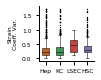

In [12]:
fig, ax = plt.subplots(figsize=(1,1))
c='k'
g = sns.boxplot(data=cell_coefvar_list,
                boxprops=dict(edgecolor=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                palette = ['#d95f0e',
                           '#31a354',
                           '#de2d26',
                           '#756bb1'],
                ax=ax,
                width=0.5,
                linewidth=0.5,
                showfliers=True,
                # rasterized=True,
                fliersize=0.5)
# g.set(yscale="log")

ax.set_ylabel('Strain\nCoeff. Var.',
              fontsize=6)
ax.set_xticklabels(['Hep',
                    'KC',
                    'LSEC',
                    'HSC'],
                   fontsize=6);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('./fancy_figures/identity_gene_strain_coeff_var.pdf',
            bbox_inches='tight')

In [13]:
for a, b in itertools.combinations(cell_coefvar_dict.keys(), 2):
    print(a, b)
    print(mannwhitneyu(cell_coefvar_dict[a], cell_coefvar_dict[b]))

hepatocyte kupffer
MannwhitneyuResult(statistic=267095.0, pvalue=0.3054301679524909)
hepatocyte lsec
MannwhitneyuResult(statistic=5760.0, pvalue=0.000481881423384552)
hepatocyte stellate
MannwhitneyuResult(statistic=150154.0, pvalue=1.9754255161173307e-22)
kupffer lsec
MannwhitneyuResult(statistic=3636.0, pvalue=0.0010307851678402252)
kupffer stellate
MannwhitneyuResult(statistic=92877.0, pvalue=3.323281277977909e-17)
lsec stellate
MannwhitneyuResult(statistic=3971.0, pvalue=0.07586227355093741)


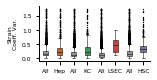

In [14]:
fig, ax = plt.subplots(figsize=(2,1))
c='k'
g = sns.boxplot(data=cell_coef_var_list_incl_all_genes,
                palette = ['#969696', '#d95f0e',
                           '#969696', '#31a354',
                           '#969696', '#de2d26',
                           '#969696', '#756bb1'],
                boxprops=dict(edgecolor=c),
                capprops=dict(color=c),
                whiskerprops=dict(color=c),
                flierprops=dict(color=c, markeredgecolor=c),
                medianprops=dict(color=c),
                ax=ax,
                width=0.4,
                linewidth=0.5,
                showfliers=True,
                fliersize=0.5)
# g.set(yscale="log")

ax.set_ylabel('Strain\nCoeff. Var.')
ax.set_xticklabels(['All', 'Hep',
                    'All', 'KC',
                    'All', 'LSEC',
                    'All', 'HSC']);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('./fancy_figures/identity_gene_strain_coeff_var_all.pdf',
            bbox_inches='tight')

# How many of the top expressed genes are differential?

Kupffer cells

In [188]:
comps = ['aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt',
         '/aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt',
         '/balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt']

ids = [['AJ.*Kup', 'BALB.*Kup'],
       ['AJ.*Kup', 'C57.*Kup'],
       ['BALB.*Kup', 'C57.*Kup']]

labels = [['AJ', 'BALB/cJ'],
          ['AJ', 'C57BL/6J'],
          ['BALB/cJ', 'C57BL/6J']]

colors = [['#636363', '#de2d26'],
          ['#636363', '#de2d26'],
          ['#636363', '#de2d26']]

# set plotting thresholds
pthresh = 0.05
fontsize=8
labelsize=6
lfcthresh = (1,2)
dotsize = 0.5
ax_max = 16
n_yticks = 5
ytickstep = 3
color = '#636363'


aj_kupffer_control_young.vs.balbc_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7612, 14)
ge selected transcripts (7612, 43)
7612 genes
573 core kc genes
22/92 KC genes up
34/99 KC genes down
/aj_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7652, 14)
ge selected transcripts (7652, 43)
7652 genes
573 core kc genes
29/125 KC genes up
41/159 KC genes down
/balbc_kupffer_control_young.vs.c57_kupffer_control_young.scatter.homer.txt
ge all transcripts (24940, 43)
Diff Gene selected transcripts (7659, 14)
ge selected transcripts (7659, 43)
7659 genes
573 core kc genes
55/180 KC genes up
52/179 KC genes down


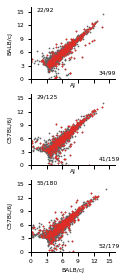

In [190]:
fig, axs = plt.subplots(3,1, figsize=(1.5,4.5), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2,
                    hspace=0.2)

# set count for labeling axes
count=0


for comp, grep, labs, color, ax in zip(comps, ids, labels, colors, axs.reshape(-1)):
    print(comp)
    de, tpm, tpm_mat, tpm_mat_quant = import_homer_diffgene(
        dataDirectory+'./differential/'+comp,
        dataDirectory+'./expression/HOMER.rawTPM.txt',
        gene_name_index=True)
    
    # extract columns
    g0 = tpm_mat.columns.str.contains(grep[0])
    g1 = tpm_mat.columns.str.contains(grep[1])
    col = g0 | g1
    
    de['logtpm'] = np.log2(tpm_mat.loc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.padj + 10**(-50))
    de['g0_mean'] = np.log2(tpm_mat.loc[:, g0].mean(1)+1)
    de['g1_mean'] = np.log2(tpm_mat.loc[:, g1].mean(1)+1)
       
    # plot group by group scatter:
    de_all = de
    de_kc_spec = de.reindex(cell_spec_dict['kupffer']).dropna()
    de_sig_fc1 = de.reindex(de.index[(de.padj < pthresh) & (np.abs(de.log2FoldChange) >= lfcthresh[0])])
    
    # genes up in group 1
    de_sig_fc1_up = de_sig_fc1.index[de_sig_fc1.log2FoldChange >= lfcthresh[0]].to_list()
    de_sig_fc1_dn = de_sig_fc1.index[de_sig_fc1.log2FoldChange <= -lfcthresh[0]].to_list()
    
    # find overlap
    kc_up = set(de_sig_fc1_up).intersection(cell_spec_dict['kupffer'])
    kc_dn = set(de_sig_fc1_dn).intersection(cell_spec_dict['kupffer'])
        
    # check number of peaks in each group
    print(de_all.shape[0], 'genes')
    print(len(cell_spec_dict['kupffer']), 'core kc genes')
    print('%i/%i KC genes up' % (len(kc_up), len(de_sig_fc1_up)))
    print('%i/%i KC genes down' % (len(kc_dn), len(de_sig_fc1_dn)))
    
    for df, c in zip([de_all, de_kc_spec],
                     color):
        ax.scatter(
            x=df.g0_mean,
            y=df.g1_mean,
            c=c,
            s=dotsize,
            rasterized=True)
        
    ax.text(1, 15, '%i/%i' % (len(kc_up), len(de_sig_fc1_up)))
    ax.text(13, 1, '%i/%i' % (len(kc_dn), len(de_sig_fc1_dn)))
    
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    # set labels
    ax.set_xlabel(labs[0])
    ax.set_ylabel(labs[1])
    #set max and min
    ax.set_xlim([0,ax_max])
    ax.set_ylim([0,ax_max])
    # set ticks
    ax.set_xticks(np.arange(0,ax_max,ytickstep))
    ax.set_xticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
    ax.set_yticks(np.arange(0,ax_max,ytickstep))
    ax.set_yticklabels(np.arange(0,ax_max,ytickstep),
                       fontdict={'fontsize':labelsize})
# plt.savefig('./fancy_figures/'+filename, bbox_inches='tight')

In [163]:
fc = 3
tpm_filt = 4

cell_spec_dict = {}
cell_var_dict = {}
cell_var_list = []
cell_coefvar_list = []

for cell in ['hepatocyte', 'kupffer', 'lsec', 'stellate']:
    cell_avg_tpm = df.loc[:, df.columns.str.contains(cell)].mean(1)
    # cell_avg_tpm = cell_avg_tpm.loc[cell_avg_tpm>4]
    other_cell_avg_tpm = []
    for other_cell in comp_cell_dict[cell]:
        other_cell_avg_tpm.append(df.loc[:, df.columns.str.contains(other_cell)].mean(1))
        
    cell_spec_bool = ((cell_avg_tpm>(fc*other_cell_avg_tpm[0])) & (cell_avg_tpm>(fc*other_cell_avg_tpm[1]))) & (cell_avg_tpm>(fc*other_cell_avg_tpm[2]))
    cell_min_expression = (cell_avg_tpm > tpm_filt)
    cell_spec_genes = cell_avg_tpm.index[(cell_spec_bool & cell_min_expression)].to_list()
    cell_spec_dict[cell] = cell_spec_genes
    cell_var_dict[cell] = df.loc[cell_spec_genes, df.columns.str.contains(cell)].sem(1).tolist()
    cell_var_list.append(np.array(df.loc[cell_spec_genes, df.columns.str.contains(cell)].sem(1).tolist()))
    
    coeff_var = df.loc[cell_spec_genes, df.columns.str.contains(cell)].std(1) / df.loc[cell_spec_genes, df.columns.str.contains(cell)].mean(1)
    cell_coefvar_list.append(coeff_var)
    
    print(cell)
    print(len(cell_avg_tpm.index[(cell_spec_bool & cell_min_expression)].to_list()))

hepatocyte
1068
kupffer
727
lsec
178
stellate
528


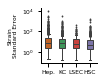

In [164]:
fig, ax = plt.subplots(figsize=(1,1))

g = sns.boxplot(data=cell_var_list,
                palette = ['#d95f0e', '#31a354', '#de2d26', '#756bb1'],
                ax=ax,
                width=0.4,
                linewidth=1,
                showfliers=True,
                fliersize=1)
g.set(yscale="log")

ax.set_ylabel('Strain\nStandard Error')
ax.set_xticklabels(['Hep.', 'KC', 'LSEC', 'HSC']);

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('./fancy_figures/identity_gene_strain_standard_error.pdf',
            bbox_inches='tight')